In [2]:
%run import.py
%run grid_search_code.py


# Grid Search #

Now that we know how to analyze how well a model will generalize to a given datset we can look at improving the models preformance. THis means tuning the hyper-paramters of the model to give the best preformance. The most common approach to this is known as a grid search. Since this is regularly used when developing machine leaning models there is a built in module in scikit-learn. To look at the grid search we will consider the case of kernel SVM and a radial basis function kernel on the iris dataset. For kernel SVM there are two paramters the regularization parameter C and the kernel bandwidth gamma. To preform a grid serach we might consider  .001, .01, .1, 10, and 100 for C and gamma. Since we have 6 values for each paramter we have 36 combinations of paramters in total. To implement a grid serach we can just run 2 for loops over the two paramters and train and evaluate a classifier for each combination:

In [4]:
from sklearn.svm import SVC
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print("Size of training set: {} size of test set: {}".format(X_train.shape[0], X_test.shape[0]))
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]: 
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
            # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_test, y_test)
        # if we got a better score, store the score and parameters 
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
print("Best score: {:.2f}".format(best_score)) 
print("Best parameters: {}".format(best_parameters))

Size of training set: 112 size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


We might think that we could claim that we found a model that is 97% accurate on our data set. At best this is an overly optimistic claim and at worst just plain wrong. We picked the best paramters on our test set but this may not be true for new data. We used our test set to find the paramters therfore we can not use it to assess how good our model is. We need unseen data for this purpose. One way to resolve this is to split the data one more time into a validation set to select the paramters from and the test set would evaluate the preforemance of the selected parameters. Once we have selected the best paramters using the validation set we can combine it with the training set to develop a final model and check its accuracy on the test set. This leads to the following implementation:

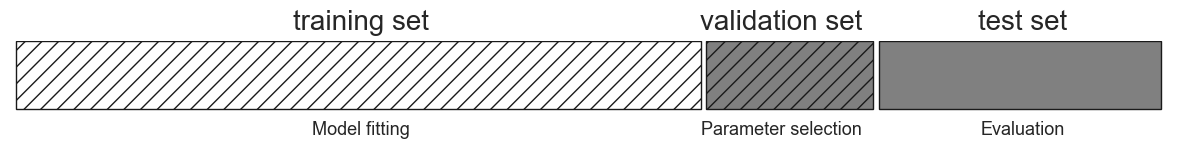

In [7]:
plot_threefold_split()

In [9]:
from sklearn.svm import SVC
# split data into train+validation set and test set 
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
# split train+validation set into training and validation sets 
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
print("Size of training set: {} size of validation set: {} size of test set:"
" {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0])) 
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]: 
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the validation set
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters 
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# rebuild a model on the combined training and validation set, # and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score)) 
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))


Size of training set: 84 size of validation set: 28 size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


Here we have an accuract of 96% on the validation set which is slightly lower because we have a smaller set we are testing on. The important score is the accuracy on the test set which is only 92% so we can only classify the data with 92% accuracy. It is important when doing model selection and exploratory analysis to reserve a test set for the end and do all the analysis on a training and validation set before exposing the model to the test set.

## Grid Search with Cross-Validation

Now in order to increase our reliability about the generalization of our model we can combine the grid serach with cross-validation on the training and validation sets. This can be coded as follows:

In [12]:
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]: 
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5) # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters 
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# rebuild a model on the combined training and validation set 
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score)) 
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Best score on validation set: 0.97
Best parameters:  {'C': 10, 'gamma': 0.1}
Test set score with best parameters: 0.97


The overall proccess of spltting the data and running the grid is shown below

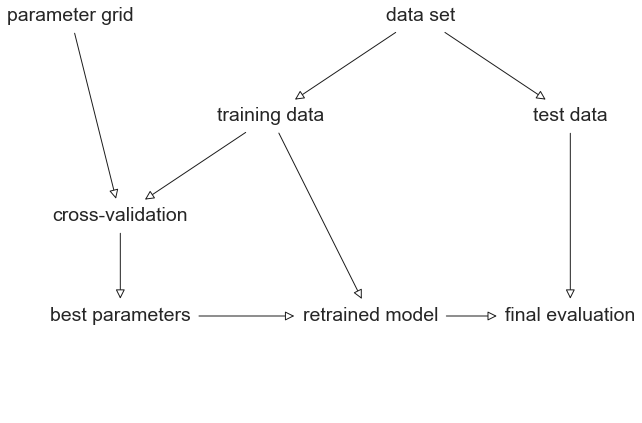

In [14]:
plot_grid_search_overview()

Because grid search with cross validation is commonly used there is a class in scikit learn that implements this. It is calles GridSearchCV. With this class you need to define the paramters you want to serach over using a dictionary where the keys are the names of the paramters you want to adjust. For the grid we have been searching over it would look like:

In [19]:
 param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


We can instantiate the GridSearchCV class with the model (in our case SVC) the parameter grid, and the cross-validation strategy we want to use (5-fold cross-validation):


In [21]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5,return_train_score=True)

We still need to split the data into training and testing sets but we will run the grid search only on the training set:

In [23]:
 X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

We can call the fit predict and score methods since it is a classifier

In [25]:
grid_search.fit(X_train, y_train);

This line of code not only does the grid search with cross-validation but also creates a model with the best parameters and trains it on the trining set. Therefore we can then use the score mehtod to see how well it preforms on the test set:

In [27]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.97


Choosing the paramter through cross-validation has actually produced a model that achieves 97% accuracy on the test set. The important thing to remember here is the test set was not used to find the paramters. We can find the best parameters in the best_params attribute and the best crossvalidation score in the best_score_ attribute:

In [29]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.1}
Best cross-validation score: 0.97


We can aslo get the whole best mdel details using the best_estimator_ attribute:

In [55]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
SVC(C=10, gamma=0.1)


We may also want to visualize the results of our grid search to understand how the model changes when we change the paramters. This can help to determine if we need to refine our grid or change the values all together. The results of the grid search can be found in the `cv_results_` attribute which is a dictonary of all aspects of the search. We can first turn it into a data frame to inspect it:

In [31]:
# convert to DataFrame
results = pd.DataFrame(grid_search.cv_results_) 
# show the first 5 rows 
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.001942,0.001543,0.000711,0.000123,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,...,0.366403,0.022485,22,0.370787,0.370787,0.366667,0.366667,0.355556,0.366092,0.005581
1,0.000837,0.000238,0.000438,0.000131,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,...,0.366403,0.022485,22,0.370787,0.370787,0.366667,0.366667,0.355556,0.366092,0.005581
2,0.000529,0.000045,0.000358,0.000081,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,...,0.366403,0.022485,22,0.370787,0.370787,0.366667,0.366667,0.355556,0.366092,0.005581
3,0.000471,0.000069,0.000281,0.000021,0.001,1,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,...,0.366403,0.022485,22,0.370787,0.370787,0.366667,0.366667,0.355556,0.366092,0.005581
4,0.000460,0.000033,0.000291,0.000092,0.001,10,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,...,0.366403,0.022485,22,0.370787,0.370787,0.366667,0.366667,0.355556,0.366092,0.005581


Each row is a set of aparmaters and each column is the scores and timing of the cross validation. Since we are looking at a 2D paramter space it is best visualized by a heat map:

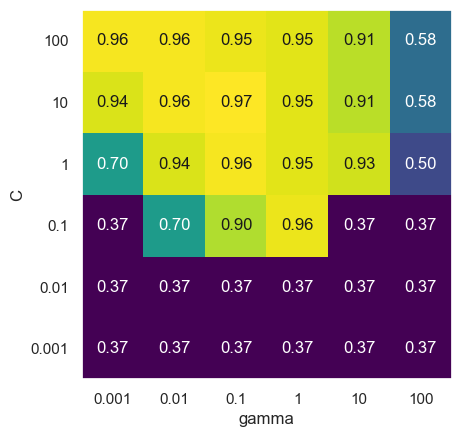

In [33]:
scores = np.array(results.mean_test_score).reshape(6, 6)
# plot the mean cross-validation scores
heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'], ylabel='C', yticklabels=param_grid['C'], cmap="viridis")

Each box represents a run of cross-validation with that set of paramters. The color encodes the accuracy. You can see that this model is quite sensative to the paramters for low C values the accuracy is around 40% which is not very good at all. For other settings though the accuracy reaches around 96%. There are several things we can take away from this graph. First the paramters are very important for obtaining good preformance. Both paramters matter alot as adjusting them can double the accuracy. Also the ranges we picked for the paramters are large enough because the optimal paramters are not at the edges of the plot. Now lets look at som less ideal plots:

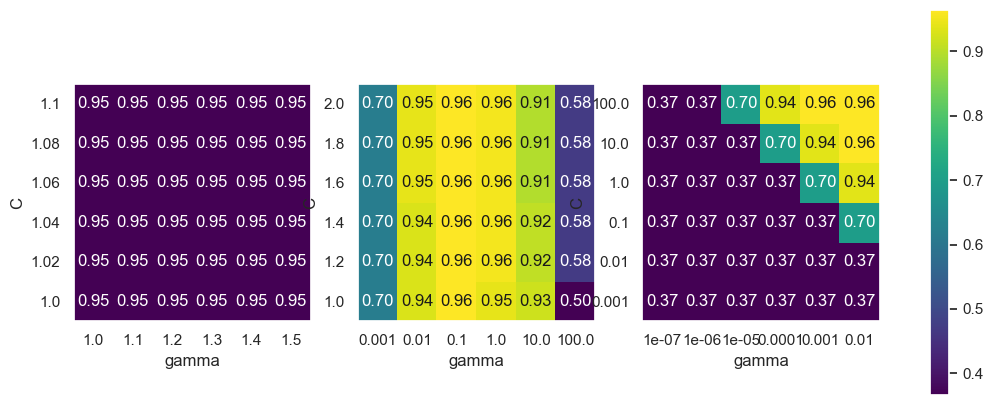

In [35]:
 fig, axes = plt.subplots(1, 3, figsize=(13, 5))
param_grid_linear = {'C': np.linspace(1, 1.1, 6),'gamma':  np.linspace(1, 1.5, 6)}
param_grid_one_log = {'C': np.linspace(1, 2, 6),'gamma':  np.logspace(-3, 2, 6)}
param_grid_range = {'C': np.logspace(-3, 2, 6),'gamma':  np.logspace(-7, -2, 6)}
for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
        grid_search = GridSearchCV(SVC(), param_grid, cv=5)
        grid_search.fit(X_train, y_train)
        scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)
        # plot the mean cross-validation scores
        scores_image = heatmap(scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],yticklabels=param_grid['C'], cmap="viridis", ax=ax)
plt.colorbar(scores_image, ax=axes.tolist())

The first panel shows that the accuracy barely changes. In this case we can tell that it is because of improper scaling of the paramters. However if no change is visible over different parameter setting, it could mean that the parameters are just not important.

The second panel shows a vertival stripe pattern. This indicates that only changing the gamma parameter makes a difference. This could also mean that the range of gamma is interesting but the range of C is not. It could also mean that the C parmater is not important.

In the third panel the accuracy changes but in the bottem left of the plot nothing interesting is happening. This idicates we could exclude extremely small values of gamma in our search. Also since the optimum is near the upper cornere we could extend the range of the search to see if there is a n ever better parmater combination.

Tuning the paramters using the cross-validation scores is a great way to explore  the importance of different paramters. The one thing to make sure of is that hrough out this procces you only want to use the training set. Once you have your optimum then you can use the test set to determine your accuracy.

### Non-Grid Spaces ###

In some cases the Grid may not alway include the same paramters fioe certain combination. For example the kernel of SVC could be 'linear' or 'rbf'. In the linear case only the C parameter is used , but in the rbf case both prameters are used. To deal woith these conditional paramters we can define the param_grid to be a list of dictionaries.Each dictionary is expanded into an independant grid. For SVC with different kerenls it may look like:

In [37]:
param_grid = [{'kernel': ['rbf'],'C': [0.001, 0.01, 0.1, 1, 10, 100],'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],'C': [0.001, 0.01, 0.1, 1, 10, 100]}] 
print("List of grids:\n{}".format(param_grid))

grid_search = GridSearchCV(SVC(), param_grid, cv=5,return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.97


We can look ath the cv_reults attributr to see how the search was conducted:

In [39]:
results = pd.DataFrame(grid_search.cv_results_)
# we display the transposed table so that it better fits on the page: 
display(results.T)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.001308,0.000754,0.000398,0.000351,0.000325,0.000315,0.000326,0.000331,0.000348,0.000327,...,0.000181,0.000224,0.000328,0.000331,0.000246,0.000215,0.000186,0.000178,0.000175,0.000186
std_fit_time,0.000475,0.000631,0.000106,0.000023,0.000014,0.000023,0.000031,0.000024,0.00003,0.000007,...,0.000009,0.000007,0.000006,0.000006,0.000007,0.000002,0.000001,0.000011,0.000009,0.000012
mean_score_time,0.000944,0.000325,0.000236,0.000195,0.000186,0.000187,0.000197,0.000207,0.000211,0.000195,...,0.000125,0.000131,0.000154,0.000171,0.000131,0.000125,0.000121,0.000111,0.000114,0.000115
std_score_time,0.000622,0.000227,0.00008,0.000009,0.000018,0.000015,0.000018,0.000021,0.000017,0.000006,...,0.000008,0.000003,0.000001,0.000005,0.000007,0.000001,0.000001,0.000005,0.000003,0.000002
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1.0,0.956522,0.869565,0.521739,0.347826,0.869565,1.0,1.0,1.0,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,0.956522,0.956522,0.913043,0.521739,0.347826,0.869565,0.913043,0.956522,1.0,0.956522


### Nested Cross-validation ###

So far we have looked at spliting into training and testing set and doing the grid serach with cross-validation on the training set. Another way to obtain the best model gneralization is to do cross-validation on the grid search itself. Rember this will not return a model but the accuracy of multiple models. This is called nested cross-validation. This can be implemented in skikit-learn by calling cross_val_score with an instance of GridSerachCV as the model:

In [61]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores) 
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.96666667 1.         0.96666667 0.96666667 1.        ]
Mean cross-validation score:  0.9800000000000001


The result can be summerized as SVC can achieve 98% mean cross-validation accuracy on the iris dataset. Here we used a stratified 5-fold cross validation in both the inner and the outer loop. This means we trained 900 models making nested cross-validation very expensive. You do not have to use the same cross-validation technique in both inner and outer loops. The single line shown above can be a little tricky to interpret so we can use a different implementation that uses for loops:

In [62]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid): 
    outer_scores = []
    # for each split of the data in the outer cross-validation
    # (split method returns indices of training and test parts)
    for training_samples, test_samples in outer_cv.split(X, y): 
        # find best parameter using inner cross-validation 
        best_parms = {}
        best_score = -np.inf
        # iterate over parameters
        for parameters in parameter_grid:
            # accumulate score over inner splits 
            cv_scores = []
            # iterate over inner cross-validation
            for inner_train, inner_test in inner_cv.split(X[training_samples], y[training_samples]):
                # build classifier given parameters and training data 
                clf = Classifier(**parameters) 
                clf.fit(X[inner_train], y[inner_train])
                # evaluate on inner test set
                score = clf.score(X[inner_test], y[inner_test]) 
                cv_scores.append(score)
            # compute mean score over inner folds
            mean_score = np.mean(cv_scores) 
            if mean_score > best_score:
                # if better than so far, remember parameters
                best_score = mean_score
                best_params = parameters
        # build classifier on best parameters using outer training set 
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        # evaluate
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

#running code
from sklearn.model_selection import ParameterGrid, StratifiedKFold 
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5),StratifiedKFold(5), SVC, ParameterGrid(param_grid)) 
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96666667 1.         0.96666667 0.96666667 1.        ]


Bad pipe message: %s [b'\xd9\x18K\xa1akUW\x92\xf4\x9a\x04Q\x96\xd2`\xca\xd7\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00', b"\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0\x18\xc0\x19\xc0#\xc0$\xc0%\xc0&\xc0

### Parallelizing cross-validation and grid search ###

Running these grid searches over many paramters can be combersome but is extremely pallelizable. This is beacuse building and testing a set of paramters on the trianing and validation setscan be done indepndentely for each set of paramters. This makes cross-validation and grid search a great candidate for parallelization. You can make use of multiple cores in GridSearchCV and cross_val_score by setting the n_jobs paramter to the number of cores you want to use. Setting n_jobs=-1 usses all available cores. For very large datasets using many cores could use large amounts of memory so you should monitor your memory when building large models in parallel. It is also possible to pallelize these algorithms over a cluster of machines using the distributed computing package `dask`.